In [1]:
from model import CNN
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
CHANNELS_D = 3

img_size = 400
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "model.pth"
data_dir = "~/Documents/datasets/archive/caltech101_classification/"

classes = ["Motorcycle", "Airplane", "Schooner"]

In [2]:
def norm_transforms(dir):
    transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ]
    )
    dataset = datasets.ImageFolder(root=dir, transform=transform)
    # concat image data (CxWxH) in tensor, discard labels
    imgs = torch.stack([img_t for img_t, _ in dataset], dim=3)
    # flatten the three channels of all images and take the mean
    mean = np.array([m for m in imgs.view(3, -1).mean(dim=1)])
    std = np.array([s for s in imgs.view(3, -1).std(dim=1)])

    norm = transforms.Normalize(
        mean = mean,
        std = std
    )
    unorm = transforms.Normalize(
        mean = -(mean/std),
        std = (1 / std)
    )
    
    return norm, unorm

norm, unorm = norm_transforms(data_dir)

In [3]:
def load_data(dir):
    transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            norm,
        ]
    )
    dataset = datasets.ImageFolder(
        root=dir,
        transform=transform)

    train_size = int(0.6 * len(dataset))
    test_val_size = len(dataset) - train_size
    train_data, test_val_data = torch.utils.data.random_split(dataset, [train_size, test_val_size])

    val_size = int(0.5 * len(test_val_data))
    test_size = len(test_val_data) - val_size
    val_data, test_data = torch.utils.data.random_split(test_val_data, [val_size, test_size])
    
    return train_data, val_data, test_data
train_data, val_data, test_data = load_data("~/Documents/datasets/archive/caltech101_classification/")

In [4]:
def gen_layers(num_layers, expansion):
    layers = []
    in_channels = 3
    
    # use batchnorm to prevent over/under shooting
    for i in range(num_layers):
        out_channels = expansion(in_channels)
        # out_channels = expansion * in_channels
        layers += [nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2)]
        layers += [nn.ReLU(), nn.BatchNorm2d(out_channels, affine=False)]
        layers += [nn.MaxPool2d(2, 2)]
        in_channels = out_channels

    # num params
    # print(((img_size // (2 ** num_layers)) ** 2) * in_channels)
    fcl = ((img_size // (2 ** num_layers)) ** 2) * in_channels
    layers += [nn.Flatten(1), nn.BatchNorm1d(fcl, affine=False), nn.Linear(fcl, 256)]
    layers += [nn.ReLU(), nn.Linear(256, 3), nn.ReLU()]
    
    return nn.Sequential(*layers)

class CNN(nn.Module):
    def __init__(self, num_layers, expansion):
        super().__init__()
        self.expansion = expansion
        self.num_layers = num_layers
        self.net = nn.Sequential(
            gen_layers(self.num_layers, self.expansion)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
def train(model, train_data, batch, epochs, lr):
    CHANNELS_D = 3
    # LEARNING_RATE = 1e-4

    loader = DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=2)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (imgs, labels) in enumerate(tqdm(loader)):
            inputs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'epoch: {epoch + 1} loss: {running_loss / batch:.6f}')
        losses.append((epoch, float(f"{(running_loss / batch):.6f}")))
        running_loss = 0.0
    
    return losses

def save(model, path):
    torch.save(model.state_dict(), path)

In [6]:
def sample(model, test_data):
    with torch.no_grad():
        figure = plt.figure(figsize=(10, 8))
        cols, rows = 4, 4
        correct = 0

        for i in range(1, cols * rows + 1):
            rand = torch.randint(len(test_data), size=(1,)).item()
            img, label = test_data[rand]
            img_input = img.to(device).unsqueeze(0)

            figure.add_subplot(rows, cols, i)
            img = unorm(img)
            npimg = np.transpose(img.numpy(), (1, 2, 0))

            plt.title(f"({i}) {classes[label]}")
            plt.axis("off",)
            plt.imshow((npimg * 255).astype(np.uint8))

            pred = model(img_input).to('cpu')

            _, pred = torch.max(pred.squeeze(), 0)
    
            print(f"({i}) Prediction: {classes[pred.item()]}, Actual: {classes[label]}")
            correct += classes[pred.item()] == classes[label]
        
        print(f"\n {correct} / {cols * rows} correct -> {correct / (cols * rows) * 100} %")
        plt.show()

In [7]:
def eval(model, data):
    with torch.no_grad():
        correct = 0

        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)

            pred = model(img_input).to('cpu')
            _, pred = torch.max(pred.squeeze(), 0)
            
            correct += classes[pred.item()] == classes[label]
        return round((correct / len(data) * 100), 3)



In [ ]:
runs, expansions = [], []
lrs = [1e-4, 2e-3, 35e-4, 0.01]
num_layers = 4
# recursive expressions to use for expanding feature map from conv layer (number of kernels)
expansions.append(lambda x: x + 13)
expansions.append(lambda x: x*2 if x < 20 else x + (x // 2))
expansions.append(lambda x: x*3 if x < 50 else x + (x // 6))

for n in range(num_layers):
    for expr in expansions:
        model = CNN(n + 1, expr).to(device)
        losses = train(model, train_data, batch=100, epochs=50, lr=lrs[n])
        model.eval() # set eval for batch norm bc batch size is only 1
        accuracy = eval(model, val_data)
        runs.append((n, expr, losses, accuracy))

3->16 accuracy: 96.988
3->6 accuracy: 92.771
3->9 accuracy: 96.084
3->16->29 accuracy: 98.193
3->6->12 accuracy: 97.59
3->9->27 accuracy: 98.193
3->16->29->42 accuracy: 98.494
3->6->12->24 accuracy: 98.795
3->9->27->81 accuracy: 98.494
3->16->29->42->55 accuracy: 99.096
3->6->12->24->36 accuracy: 99.096
3->9->27->81->94 accuracy: 98.795


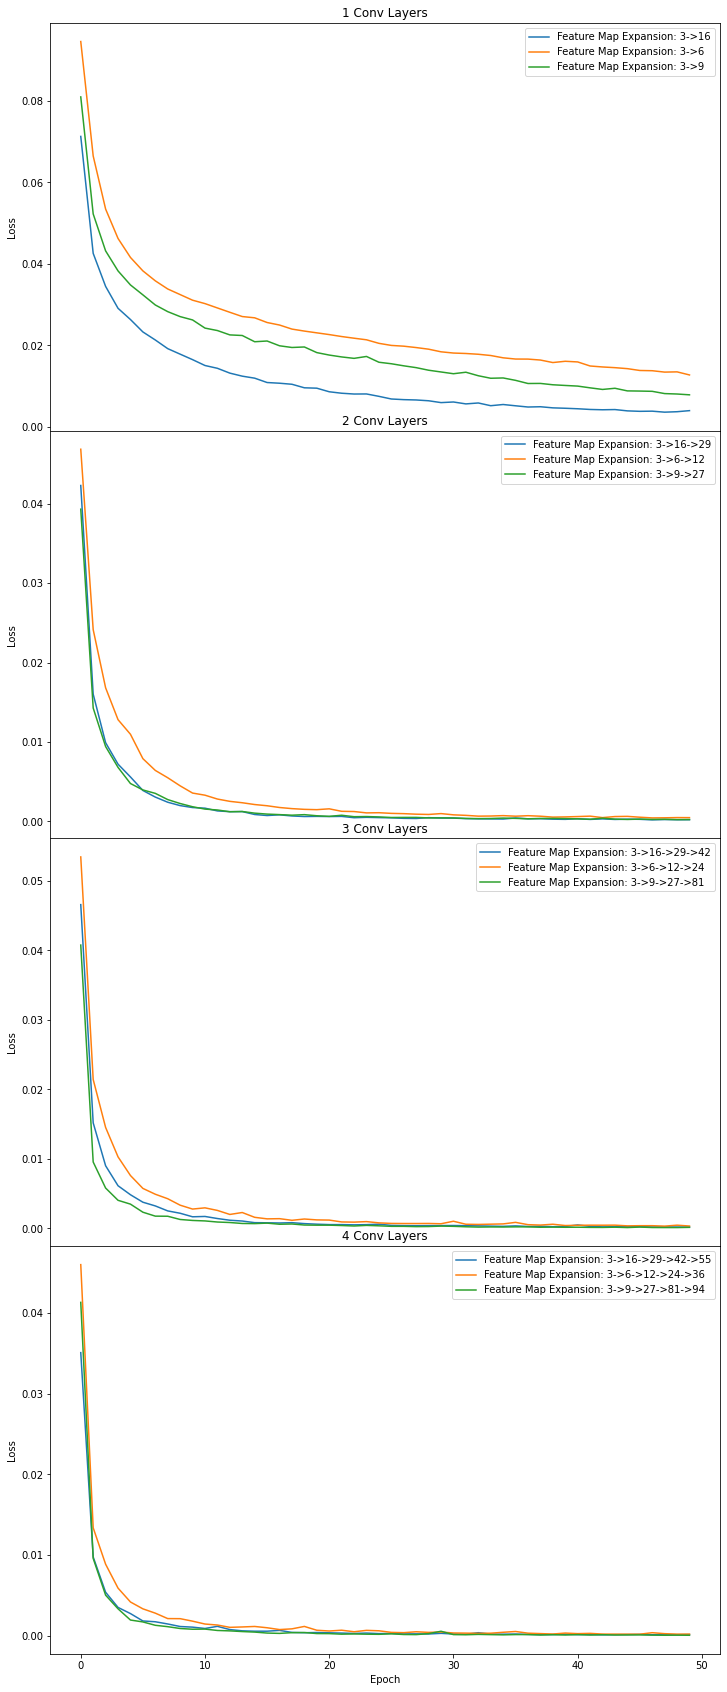

In [9]:
import math

#[(n, expr, [(epoch, loss)...])]

def plot_losses(runs):
    fig, axs = plt.subplots(num_layers, figsize=(12,30), gridspec_kw={'hspace': 0,})

    for (n_lay, expr, epoch_loss, accuracy) in runs:
        prior = CHANNELS_D
        conv_seq = str(prior)
        for i in range(n_lay +1 ):
            prior = expr(prior)
            conv_seq += f"->{str(prior)}"
        print(f"{conv_seq} accuracy: {accuracy}")
        axs[n_lay].plot(*zip(*epoch_loss), label=f"Feature Map Expansion: {conv_seq}")
        axs[n_lay].set_title(f"{n_lay + 1} Conv Layers")
        axs[n_lay].legend()
        axs[n_lay].set(xlabel="Epoch", ylabel="Loss")
    plt.show()
    
plot_losses(runs)

In [ ]:
# 3->16->29->42->55 accuracy: 99.096